### Original tf tutorial https://www.tensorflow.org/tutorials/generative/cvae

In [1]:
from IPython import display

import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
(train_images, train_targets), (test_images, test_targets) = tf.keras.datasets.mnist.load_data()

In [3]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [4]:
train_size = 60000
batch_size = 32
test_size = 10000

latent_dim = 2

In [5]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))

In [23]:
test_batch_size = 1000

test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).batch(test_batch_size))

for test_batch in test_dataset.take(1):
    test_batch_one = test_batch[0:test_batch_size, :, :, :]
    
test_targets_dataset = (tf.data.Dataset.from_tensor_slices(test_targets).batch(test_batch_size))

y = test_targets[0:test_batch_size]

In [7]:
class CAE(tf.keras.Model):
    """Convolutional autoencoder."""
    
    def __init__(self, latent_dim, model_name_to_load=None):
        super(CAE, self).__init__()
        self._latent_dim = latent_dim
        output_dim = latent_dim
        if not model_name_to_load:
            self._encoder = tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                    tf.keras.layers.Conv2D(
                        filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                    tf.keras.layers.Conv2D(
                        filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                    tf.keras.layers.Flatten(),
                    # No activation
                    tf.keras.layers.Dense(self._encoder_output_dim()),
                ]
            )

            self._decoder = tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                    tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                    tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                    tf.keras.layers.Conv2DTranspose(
                        filters=64, kernel_size=3, strides=2, padding='same',
                        activation='relu'),
                    tf.keras.layers.Conv2DTranspose(
                        filters=32, kernel_size=3, strides=2, padding='same',
                        activation='relu'),
                    # No activation
                    tf.keras.layers.Conv2DTranspose(
                        filters=1, kernel_size=3, strides=1, padding='same'),
                ]
            )
        else:
            self.load_model(model_name_to_load)
        
    def save_model(self, name):
        self._encoder.save('{}_encoder.keras'.format(name))
        self._decoder.save('{}_decoder.keras'.format(name))
        
    def load_model(self, name):
        self._encoder = keras.models.load_model('{}_encoder.keras'.format(name))
        self._decoder = keras.models.load_model('{}_decoder.keras'.format(name))

    def _encoder_output_dim(self):
        return self._latent_dim

    @tf.function
    def sample(self, eps=None):
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        return self._encoder(x)

    def decode(self, z, apply_sigmoid=False):
        logits = self._decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    def compute_loss(self, x):
        return self.compute_cross_entropy(x)
    
    def compute_cross_entropy(self, x):
        z = self.encode(x)
        x_logit = self.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        return -tf.reduce_mean(logpx_z)
    
    def generate(self, x):
        z = self.encode(x)
        return self.sample(z)
    
    
class CVAE(CAE):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim, model_name_to_load=None):
        super(CVAE, self).__init__(latent_dim, model_name_to_load)

    def _encoder_output_dim(self):
        return 2 * self._latent_dim

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self._encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def compute_loss(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(logpx_z + logpz - logqz_x)
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def generate(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.sample(z) 
    

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

In [8]:
def plot_latent_images(model, n, x_min, x_max, y_min, y_max, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = np.linspace(x_min, x_max, n)#norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = np.linspace(y_min, y_max, n)#norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])
            #print(z)
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            #print(len(grid_y), j, digit.numpy().shape)
            #print(j * digit_size, (j + 1) * digit_size)
            #print((n - j - 1) * digit_size, (n - j + 0) * digit_size)
            image[(n - i - 1) * digit_size: (n - i + 0) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()
  

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()


def train(model, epochs):
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_step(model, train_x, optimizer)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        cross_entropy_aggregator = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(model.compute_loss(test_x))
            cross_entropy_aggregator(model.compute_cross_entropy(test_x))
        elbo = -loss.result()
        cross_entropy = cross_entropy_aggregator.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, test set cross entropy: {}, time elapse for current epoch: {}'
            .format(epoch, elbo, cross_entropy, end_time - start_time))

# AE

In [11]:
optimizer = tf.keras.optimizers.Adam(1e-4)

epochs = 20

model = CAE(latent_dim)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = model.compute_loss(x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [12]:
train(model, epochs)

Epoch: 20, Test set ELBO: -152.65478515625, test set cross entropy: 152.65478515625, time elapse for current epoch: 15.785854816436768


In [24]:
mean = model.encode(test_batch_one)

x_min, y_min = mean.numpy().min(axis=0)
x_max, y_max = mean.numpy().max(axis=0)

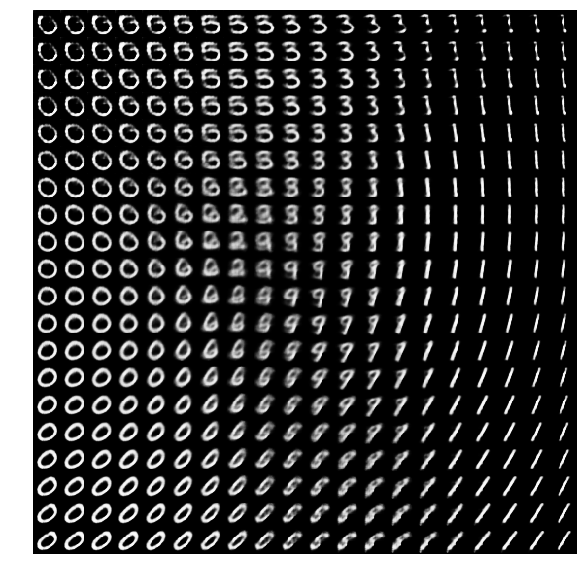

In [25]:
_ = plot_latent_images(model, 20, x_min, x_max, y_min, y_max)

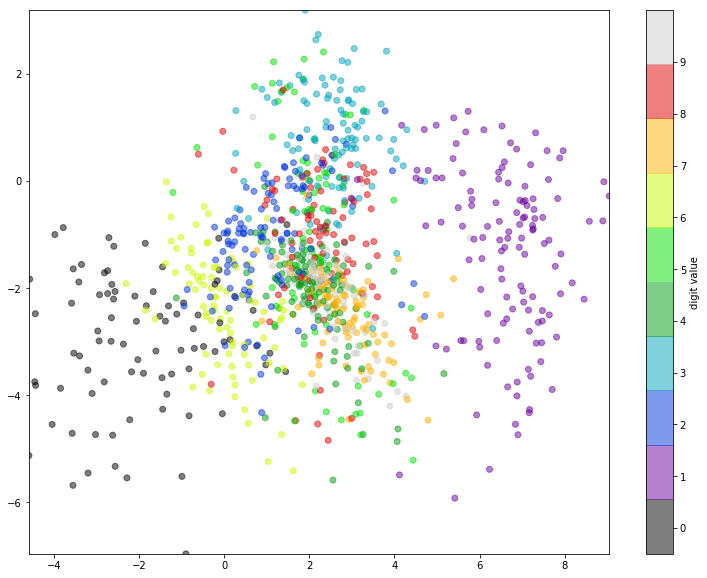

In [31]:
mean = model.encode(test_batch_one)

fig = plt.figure(figsize=(13, 10))
ax = plt.subplot(111)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.scatter(*mean.numpy().T, c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10), alpha = 0.5)
plt.colorbar(ticks=range(10), label='digit value')
plt.clim(-0.5, 10.)


# VAE

In [38]:
optimizer = tf.keras.optimizers.Adam(1e-4)

epochs = 20

model = CVAE(latent_dim)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = model.compute_loss(x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [39]:
train(model, epochs)

Epoch: 20, Test set ELBO: -153.3384246826172, test set cross entropy: 146.7132110595703, time elapse for current epoch: 15.975242614746094


In [40]:
mean, logvar = model.encode(test_batch_one)

x_min, y_min = mean.numpy().min(axis=0)
x_max, y_max = mean.numpy().max(axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



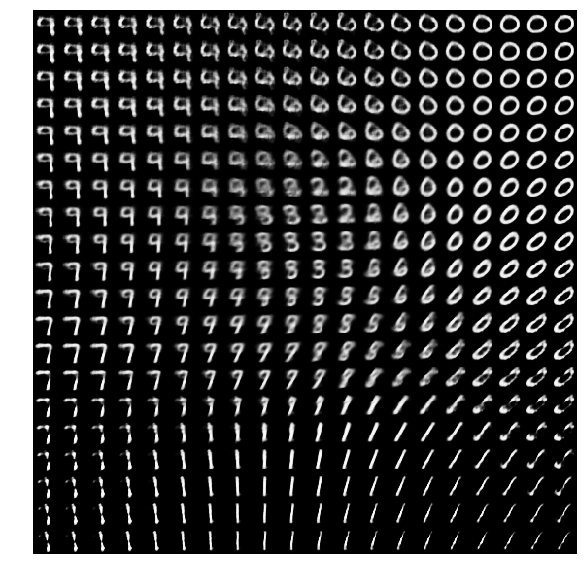

In [41]:
_ = plot_latent_images(model, 20, x_min, x_max, y_min, y_max)

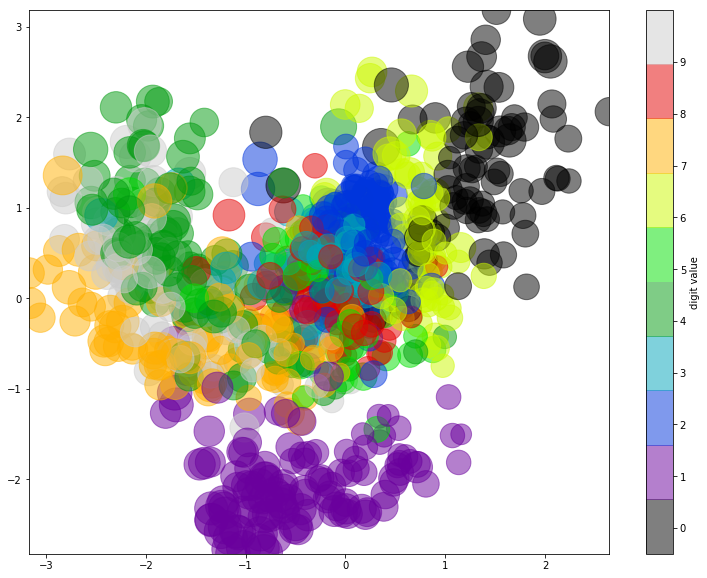

In [42]:
mean, log_var = model.encode(test_batch_one)

fig = plt.figure(figsize=(13, 10))
ax = plt.subplot(111)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.scatter(*mean.numpy().T, c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10), alpha = 0.5, s=5000 * 2 * tf.sqrt(tf.exp(logvar).numpy().mean(axis=1)))
plt.colorbar(ticks=range(10), label='digit value')
plt.clim(-0.5, 10.)


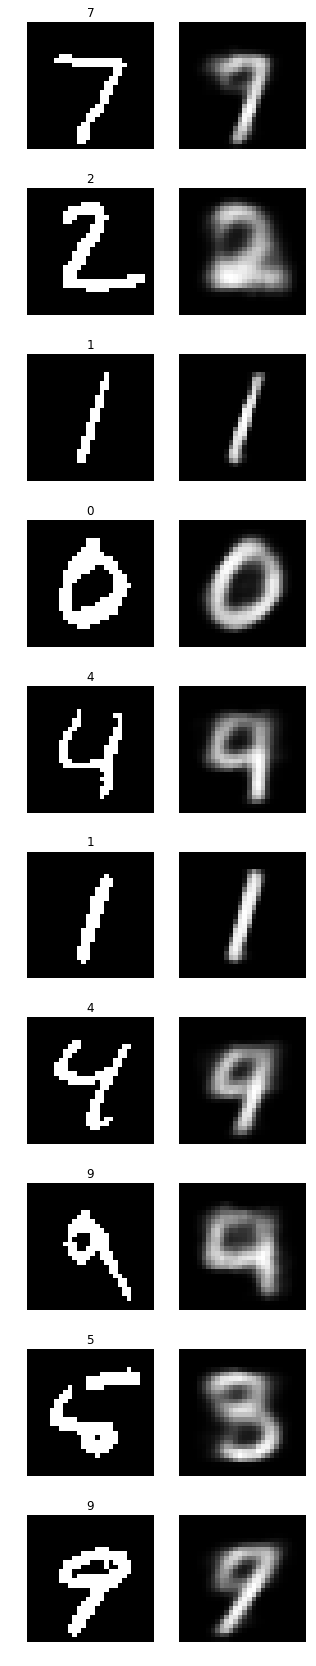

In [43]:
n = 10
mean, logvar = model.encode(test_batch_one[:n,:,:,:])
z = model.reparameterize(mean, logvar)
predictions = model.sample(z)
fig = plt.figure(figsize=(5, n * 3))

for i in range(predictions.shape[0]):
    plt.subplot(n, 2, 2 * i + 1)
    plt.imshow(test_batch_one[i, :, :, 0], cmap='gray')
    plt.title(test_targets[i])
    plt.axis('off')
    
    plt.subplot(n, 2, 2 * i + 2)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')